In [0]:
%matplotlib inline

In [0]:

import tensorflow as tf
import cv2 as cv
import os
import numpy as np
import glob
from random import shuffle
from google.colab import drive
import matplotlib.pyplot as plt

In [0]:
drive.mount("/content/drive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [0]:
folder="/content/drive/My Drive/assign-2/faces94/*/*"
nls=[]
for filename in glob.glob(folder+'/*.jpg'):
  img=cv.imread(filename)
  img=cv.resize(img,(50,50))
  nls.append(img)
  


In [0]:
number_of_images=len(nls)
print(number_of_images)
# plt.imshow(ls[19])
ls=[]
sf=[ii for ii in range(number_of_images)]
shuffle(sf)
print(sf)
for ii in sf:
  ls.append(nls[ii])
ls=np.asarray(ls)
print(ls.shape)

3059
[2350, 351, 1109, 2999, 103, 2489, 2131, 562, 789, 2430, 673, 931, 1308, 2470, 2567, 2463, 1519, 2397, 1014, 2015, 414, 1989, 1304, 2651, 2517, 1563, 1715, 1866, 2632, 207, 1331, 202, 1443, 1257, 2017, 9, 1922, 742, 1982, 1030, 1433, 3049, 2333, 1896, 2, 1061, 132, 2507, 1568, 625, 478, 285, 2217, 2233, 493, 1993, 1632, 76, 2357, 2037, 2892, 425, 357, 2249, 2974, 1126, 2000, 2835, 112, 2512, 551, 2327, 498, 3016, 2815, 158, 677, 2948, 163, 1681, 998, 131, 301, 994, 1876, 2352, 497, 302, 1789, 2518, 179, 385, 1736, 2054, 906, 1091, 1799, 50, 1163, 2980, 2686, 1735, 632, 210, 2159, 1730, 890, 2399, 1868, 71, 2867, 1547, 2549, 809, 2627, 1854, 1225, 2858, 2148, 855, 1994, 1708, 1462, 1526, 1165, 760, 1465, 1027, 2026, 2084, 1057, 309, 1765, 1596, 2064, 2395, 1364, 2734, 935, 2971, 308, 284, 36, 2419, 2392, 2536, 2782, 2520, 880, 2888, 1429, 2928, 1697, 1025, 758, 629, 18, 1294, 435, 2645, 816, 828, 518, 891, 1691, 519, 2998, 592, 2199, 2647, 1345, 1554, 111, 496, 204, 1181, 2234, 839

In [0]:
  
weights={'w_conv1':tf.Variable(xavier_init([5,5,3,32])),
       'w_conv2': tf.Variable(xavier_init([5, 5, 32, 64])),
       'w_fc': tf.Variable(xavier_init([13*13*64,128])),
       'out': tf.Variable(xavier_init([128,1])),

       'G_w1': tf.Variable(xavier_init([100,128])),
       'G_w2': tf.Variable(xavier_init([128,50*50*3])),

       'D_w1': tf.Variable(xavier_init([50*50*3,128])),
       'D_w2': tf.Variable(xavier_init([128,1])),}

biases={'b_conv1':tf.Variable(tf.zeros([32])),
       'b_conv2': tf.Variable(tf.zeros([64])),
       'b_fc': tf.Variable(tf.zeros([128])),
       'out': tf.Variable(tf.zeros([1])),

       'G_b1': tf.Variable(tf.zeros([128])),
       'G_b2': tf.Variable(tf.zeros([50*50*3])),

       'D_b1': tf.Variable(tf.random_normal([128])),
       'D_b2': tf.Variable(tf.random_normal([1])),}

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def conv2d(x,w):
    print(x.shape,w.shape)
    return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding="SAME")

def maxpool2d(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')


In [0]:
def dc_discriminator(x):
    conv1=conv2d(x,weights['w_conv1'])
    conv1=maxpool2d(conv1)

    conv2 = conv2d(conv1, weights['w_conv2'])
    conv2 = maxpool2d(conv2)
    
    fc1 = tf.reshape(conv2, [-1, weights['w_fc'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['w_fc']), biases['b_fc'])
    fc1 = tf.nn.relu(fc1)

    out_logit = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    out_prob=tf.nn.sigmoid(out_logit)
    return out_prob,out_logit
  

In [0]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, weights['G_w1']) + biases['G_b1'])
    G_log_prob = tf.matmul(G_h1, weights['G_w2']) + biases['G_b2']
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [0]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m,n])

In [0]:
def train_nn():
  X = tf.placeholder(tf.float32, shape=[None,50,50,3])
  Z = tf.placeholder(tf.float32, shape=[None,100])
  
  theta_DC_D = [weights['w_conv1'], weights['w_conv2'],weights['w_fc'], weights['out'],biases['b_conv1'], biases['b_conv2'],biases['b_fc'], biases['out']]
  theta_G=[weights['G_w1'],weights['G_w2'],biases['G_b1'],biases['G_b2']]
  
  G_sample=generator(Z)
  print("sample",G_sample.shape)
  G_sample=tf.reshape(G_sample,[-1,50,50,3])
  print("sample",G_sample.shape)
  D_prob_real,D_logit_real=dc_discriminator(X)
  D_prob_fake,D_logit_fake=dc_discriminator(G_sample)
 
  D_real_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_real,labels=tf.ones_like(D_logit_real)))
  D_fake_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_fake,labels=tf.zeros_like(D_logit_fake)))
  
  D_loss=D_real_loss+D_fake_loss
  G_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_fake,labels=tf.ones_like(D_logit_fake)))
  
  
  D_optimizer=tf.train.AdamOptimizer().minimize(D_loss,var_list=theta_DC_D)
  G_optimizer=tf.train.AdamOptimizer().minimize(G_loss,var_list=theta_G)
  
  
  sess = tf.Session()
  sess.run(tf.initialize_all_variables())
  batch_size=100
  for ep in range(1000):
    for j in range(number_of_images//batch_size):
      ls1=ls[j*batch_size:(j*batch_size+batch_size)]
      _, D_loss_curr = sess.run([D_optimizer, D_loss], feed_dict={X:ls1, Z: sample_Z(batch_size, 100)})
      gs,_, G_loss_curr = sess.run([G_sample,G_optimizer, G_loss], feed_dict={Z: sample_Z(batch_size, 100)})
    gs=gs.tolist()
    print(np.asarray(gs[0]).shape)
    plt.imshow(np.asarray(gs[0]))
    plt.show()
    print('Iter: {}'.format(ep))
    print('D loss: {:.4}'. format(D_loss_curr))
    print('G_loss: {:.4}'.format(G_loss_curr))
    print()



sample (?, 7500)
sample (?, 50, 50, 3)
(?, 50, 50, 3) (5, 5, 3, 32)
(?, 25, 25, 32) (5, 5, 32, 64)
(?, 50, 50, 3) (5, 5, 3, 32)
(?, 25, 25, 32) (5, 5, 32, 64)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
(50, 50, 3)


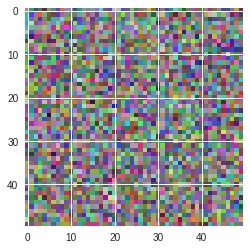

Iter: 0
D loss: 504.5
G_loss: 0.0

(50, 50, 3)


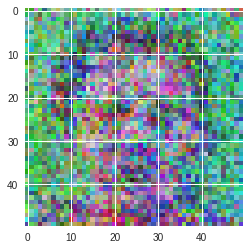

Iter: 1
D loss: 24.43
G_loss: 198.7

(50, 50, 3)


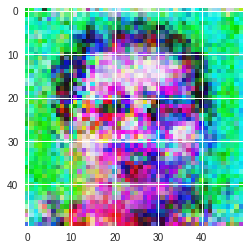

Iter: 2
D loss: 146.6
G_loss: 1.867

(50, 50, 3)


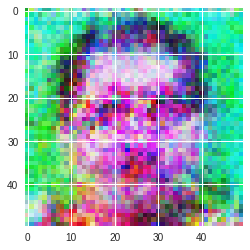

Iter: 3
D loss: 522.1
G_loss: 2.78

(50, 50, 3)


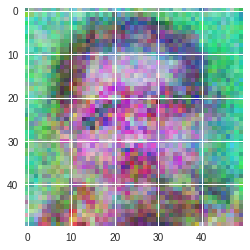

Iter: 4
D loss: 86.95
G_loss: 6.571

(50, 50, 3)


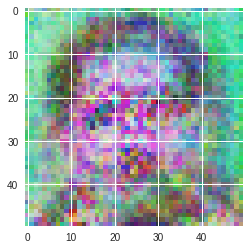

Iter: 5
D loss: 731.9
G_loss: 0.0

(50, 50, 3)


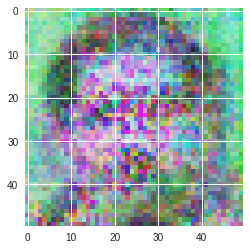

Iter: 6
D loss: 465.8
G_loss: 0.0

(50, 50, 3)


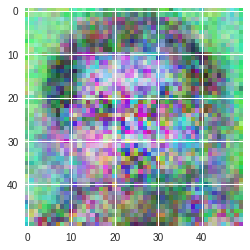

Iter: 7
D loss: 0.6131
G_loss: 65.68

(50, 50, 3)


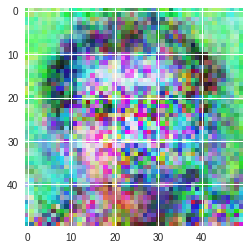

Iter: 8
D loss: 42.6
G_loss: 0.6499

(50, 50, 3)


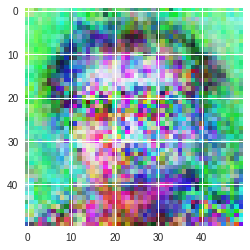

Iter: 9
D loss: 10.83
G_loss: 78.49

(50, 50, 3)


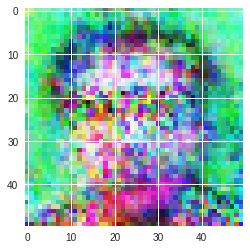

Iter: 10
D loss: 0.4159
G_loss: 98.72

(50, 50, 3)


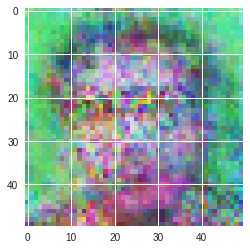

Iter: 11
D loss: 0.005138
G_loss: 209.1

(50, 50, 3)


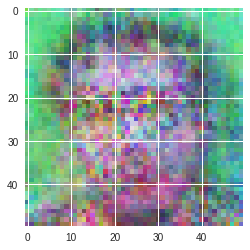

Iter: 12
D loss: 23.13
G_loss: 33.1

(50, 50, 3)


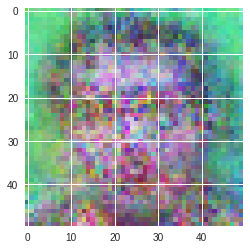

Iter: 13
D loss: 28.35
G_loss: 0.3283

(50, 50, 3)


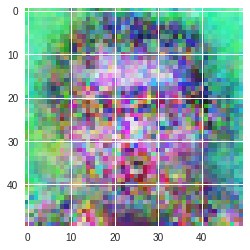

Iter: 14
D loss: 0.0
G_loss: 239.5

(50, 50, 3)


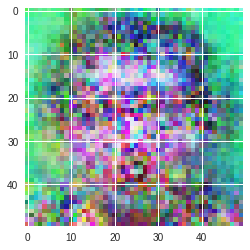

Iter: 15
D loss: 23.93
G_loss: 31.25

(50, 50, 3)


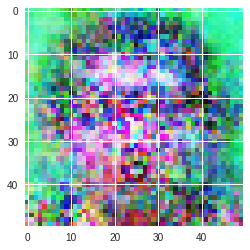

Iter: 16
D loss: 313.4
G_loss: 0.2117

(50, 50, 3)


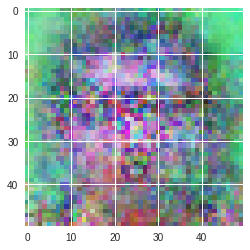

Iter: 17
D loss: 1.361
G_loss: 24.09

(50, 50, 3)


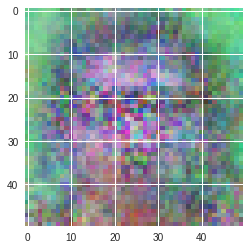

Iter: 18
D loss: 0.4272
G_loss: 125.6

(50, 50, 3)


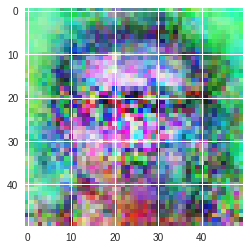

Iter: 19
D loss: 159.5
G_loss: 0.0007036

(50, 50, 3)


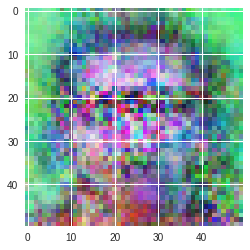

Iter: 20
D loss: 6.168e-16
G_loss: 79.75

(50, 50, 3)


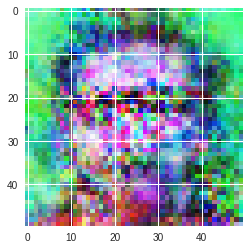

Iter: 21
D loss: 3.799e-31
G_loss: 152.9

(50, 50, 3)


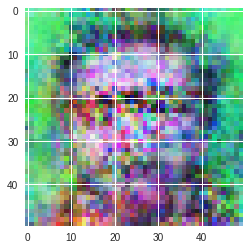

Iter: 22
D loss: 10.03
G_loss: 36.95

(50, 50, 3)


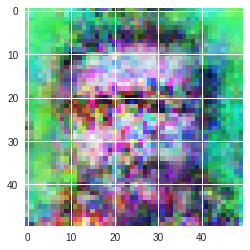

Iter: 23
D loss: 29.68
G_loss: 41.87

(50, 50, 3)


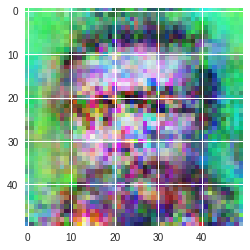

Iter: 24
D loss: 15.01
G_loss: 7.166

(50, 50, 3)


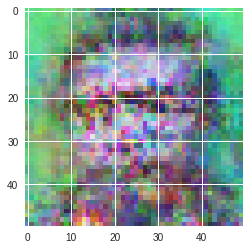

Iter: 25
D loss: 30.81
G_loss: 25.57

(50, 50, 3)


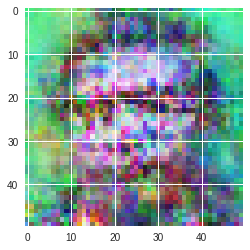

Iter: 26
D loss: 1.567
G_loss: 38.72

(50, 50, 3)


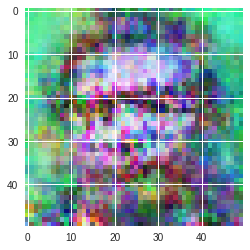

Iter: 27
D loss: 0.0
G_loss: 181.9

(50, 50, 3)


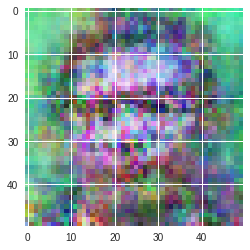

Iter: 28
D loss: 0.0
G_loss: 206.8

(50, 50, 3)


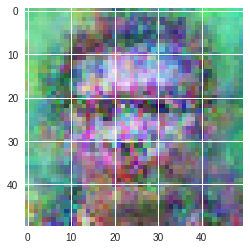

Iter: 29
D loss: 0.03096
G_loss: 91.92

(50, 50, 3)


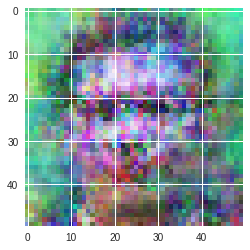

Iter: 30
D loss: 0.0
G_loss: 430.9

(50, 50, 3)


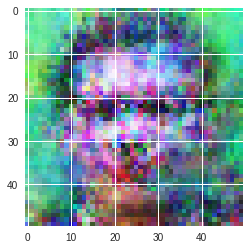

Iter: 31
D loss: 25.32
G_loss: 62.04

(50, 50, 3)


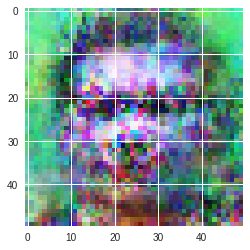

Iter: 32
D loss: 50.03
G_loss: 3.712

(50, 50, 3)


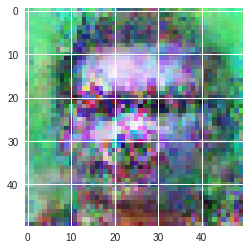

Iter: 33
D loss: 0.0
G_loss: 300.3

(50, 50, 3)


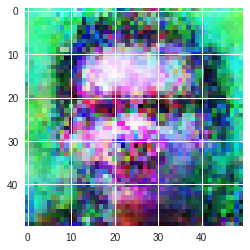

Iter: 34
D loss: 69.66
G_loss: 2.247

(50, 50, 3)


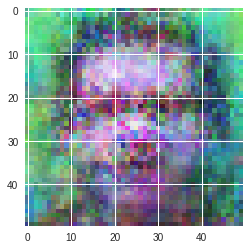

Iter: 35
D loss: 0.0
G_loss: 194.8

(50, 50, 3)


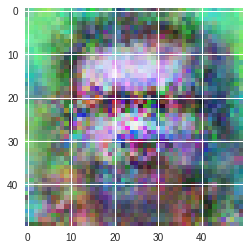

Iter: 36
D loss: 10.51
G_loss: 107.0

(50, 50, 3)


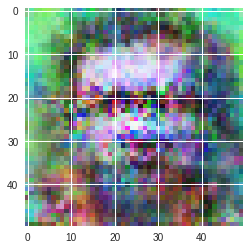

Iter: 37
D loss: 61.86
G_loss: 81.19

(50, 50, 3)


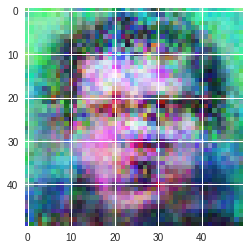

Iter: 38
D loss: 1.062e-17
G_loss: 315.5

(50, 50, 3)


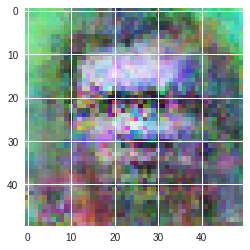

Iter: 39
D loss: 87.14
G_loss: 63.2

(50, 50, 3)


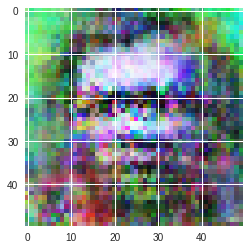

Iter: 40
D loss: 25.61
G_loss: 121.2

(50, 50, 3)


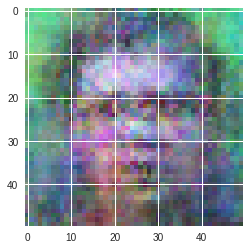

Iter: 41
D loss: 113.8
G_loss: 120.1

(50, 50, 3)


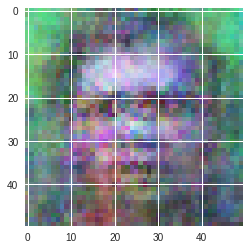

Iter: 42
D loss: 0.8893
G_loss: 184.1

(50, 50, 3)


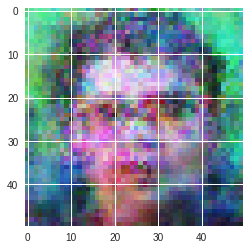

Iter: 43
D loss: 0.002189
G_loss: 121.0

(50, 50, 3)


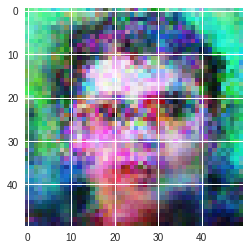

Iter: 44
D loss: 1.497e-17
G_loss: 186.1

(50, 50, 3)


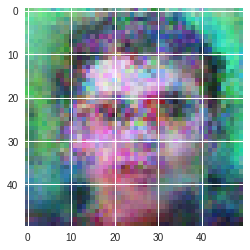

Iter: 45
D loss: 0.0
G_loss: 226.3

(50, 50, 3)


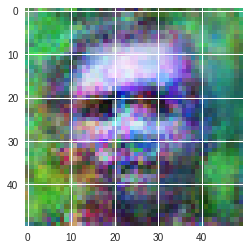

Iter: 46
D loss: 331.8
G_loss: 0.0

(50, 50, 3)


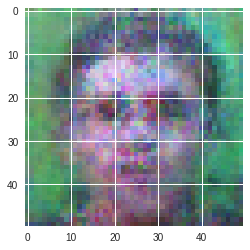

Iter: 47
D loss: 20.77
G_loss: 12.19

(50, 50, 3)


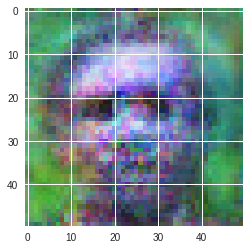

Iter: 48
D loss: 140.5
G_loss: 2.664

(50, 50, 3)


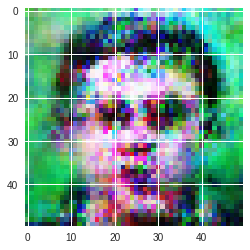

Iter: 49
D loss: 1.453e-18
G_loss: 159.0

(50, 50, 3)


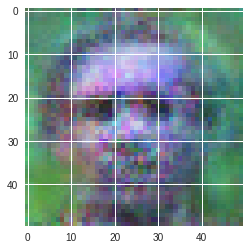

Iter: 50
D loss: 125.4
G_loss: 7.239

(50, 50, 3)


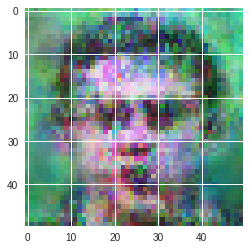

Iter: 51
D loss: 10.7
G_loss: 65.96

(50, 50, 3)


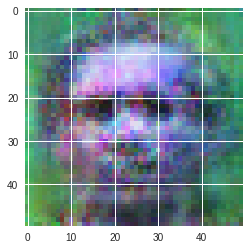

Iter: 52
D loss: 8.593
G_loss: 10.33

(50, 50, 3)


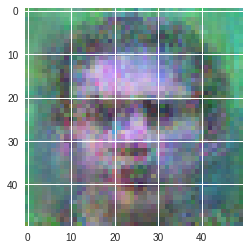

Iter: 53
D loss: 2.371
G_loss: 147.9

(50, 50, 3)


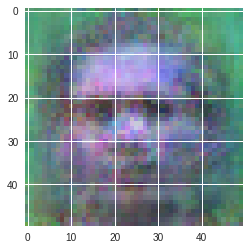

Iter: 54
D loss: 0.0007476
G_loss: 95.39

(50, 50, 3)


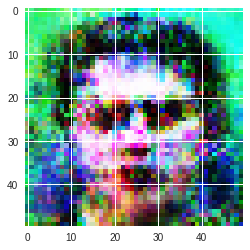

Iter: 55
D loss: 97.84
G_loss: 6.006e-36

(50, 50, 3)


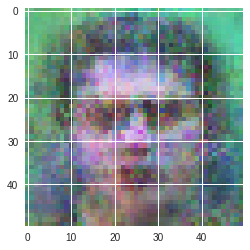

Iter: 56
D loss: 4.816
G_loss: 80.93

(50, 50, 3)


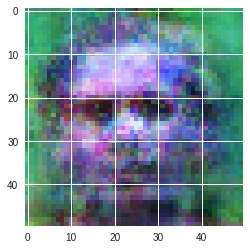

Iter: 57
D loss: 14.31
G_loss: 74.43

(50, 50, 3)


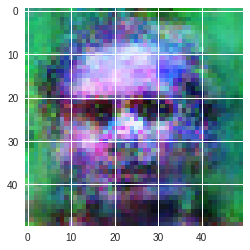

Iter: 58
D loss: 46.32
G_loss: 9.754

(50, 50, 3)


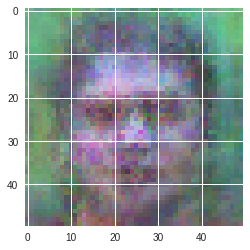

Iter: 59
D loss: 1.443
G_loss: 67.07

(50, 50, 3)


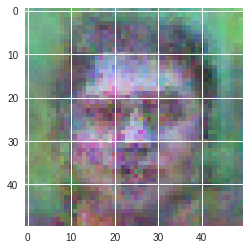

Iter: 60
D loss: 2.482e-07
G_loss: 79.52

(50, 50, 3)


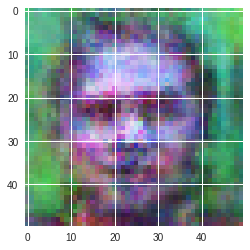

Iter: 61
D loss: 58.66
G_loss: 31.27

(50, 50, 3)


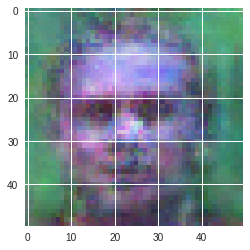

Iter: 62
D loss: 19.01
G_loss: 33.26

(50, 50, 3)


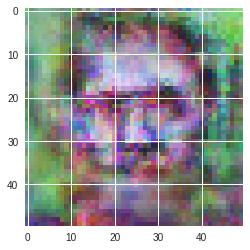

Iter: 63
D loss: 1.784
G_loss: 48.47

(50, 50, 3)


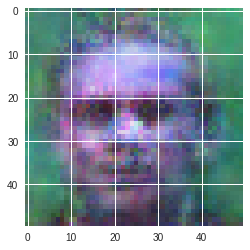

Iter: 64
D loss: 2.633
G_loss: 82.5

(50, 50, 3)


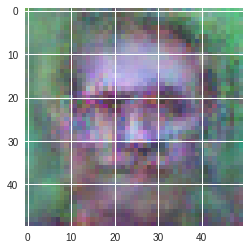

Iter: 65
D loss: 32.38
G_loss: 8.064

(50, 50, 3)


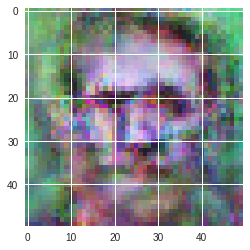

Iter: 66
D loss: 8.569
G_loss: 44.16

(50, 50, 3)


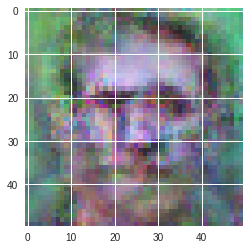

Iter: 67
D loss: 4.038
G_loss: 96.03

(50, 50, 3)


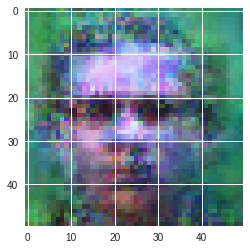

Iter: 68
D loss: 35.79
G_loss: 40.19

(50, 50, 3)


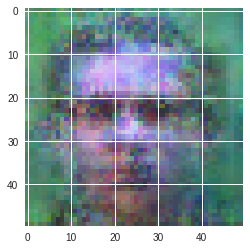

Iter: 69
D loss: 43.41
G_loss: 12.49

(50, 50, 3)


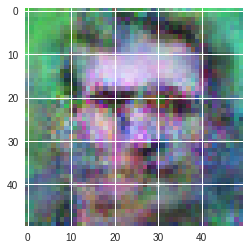

Iter: 70
D loss: 11.5
G_loss: 8.186

(50, 50, 3)


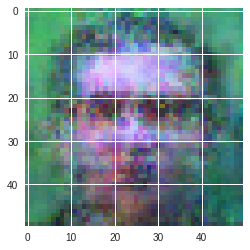

Iter: 71
D loss: 9.238
G_loss: 27.94

(50, 50, 3)


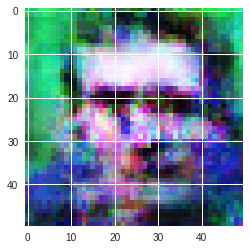

Iter: 72
D loss: 28.28
G_loss: 74.61

(50, 50, 3)


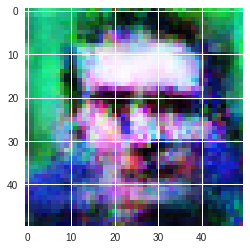

Iter: 73
D loss: 0.6202
G_loss: 97.66

(50, 50, 3)


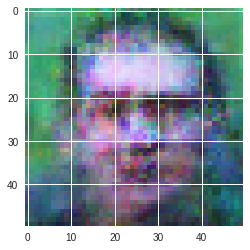

Iter: 74
D loss: 73.28
G_loss: 12.48

(50, 50, 3)


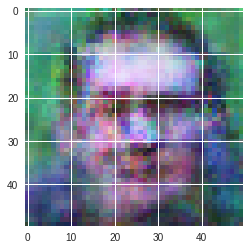

Iter: 75
D loss: 21.88
G_loss: 18.09

(50, 50, 3)


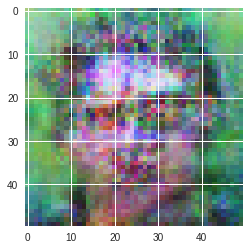

Iter: 76
D loss: 45.33
G_loss: 78.56

(50, 50, 3)


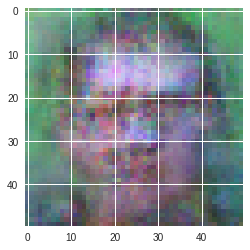

Iter: 77
D loss: 1.201
G_loss: 72.73

(50, 50, 3)


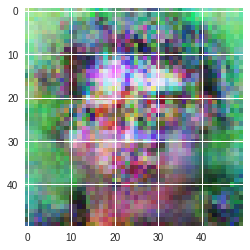

Iter: 78
D loss: 8.699e-16
G_loss: 221.6

(50, 50, 3)


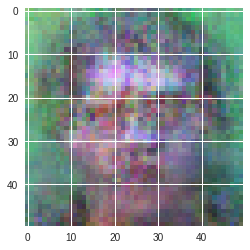

Iter: 79
D loss: 12.09
G_loss: 29.49

(50, 50, 3)


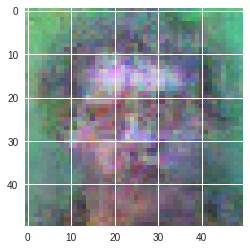

Iter: 80
D loss: 18.93
G_loss: 82.94

(50, 50, 3)


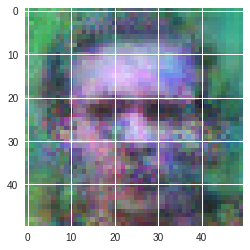

Iter: 81
D loss: 62.02
G_loss: 24.77

(50, 50, 3)


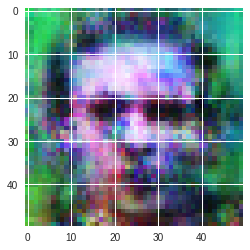

Iter: 82
D loss: 2.933
G_loss: 110.6

(50, 50, 3)


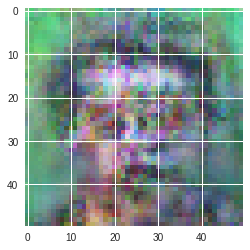

Iter: 83
D loss: 8.802
G_loss: 44.95

(50, 50, 3)


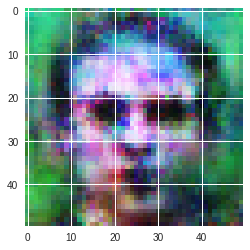

Iter: 84
D loss: 9.198
G_loss: 36.25

(50, 50, 3)


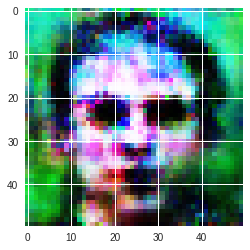

Iter: 85
D loss: 9.809
G_loss: 43.41

(50, 50, 3)


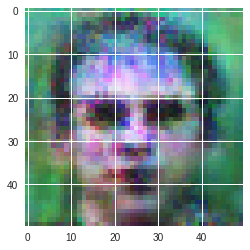

Iter: 86
D loss: 1.149e-37
G_loss: 361.9

(50, 50, 3)


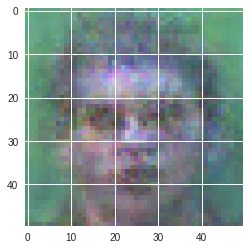

Iter: 87
D loss: 72.52
G_loss: 63.38

(50, 50, 3)


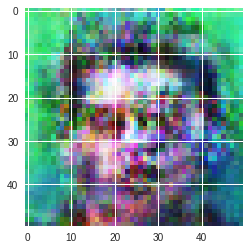

Iter: 88
D loss: 5.88
G_loss: 45.93

(50, 50, 3)


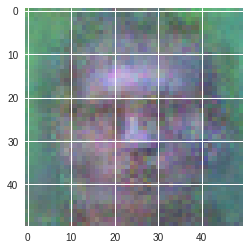

Iter: 89
D loss: 0.001079
G_loss: 164.5

(50, 50, 3)


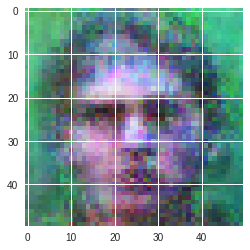

Iter: 90
D loss: 0.0
G_loss: 236.8

(50, 50, 3)


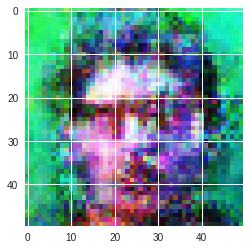

Iter: 91
D loss: 16.2
G_loss: 65.01

(50, 50, 3)


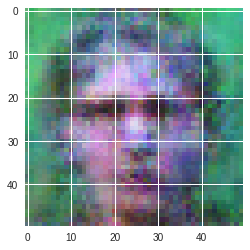

Iter: 92
D loss: 9.129
G_loss: 71.44

(50, 50, 3)


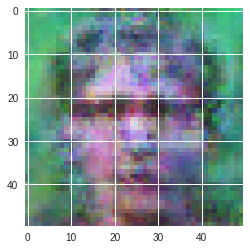

Iter: 93
D loss: 3.375
G_loss: 84.2

(50, 50, 3)


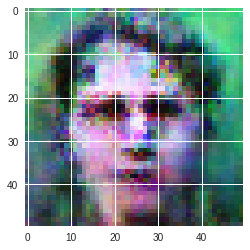

Iter: 94
D loss: 11.38
G_loss: 49.01

(50, 50, 3)


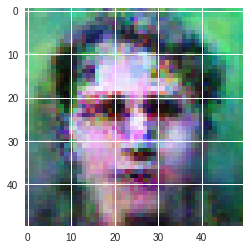

Iter: 95
D loss: 28.7
G_loss: 54.04

(50, 50, 3)


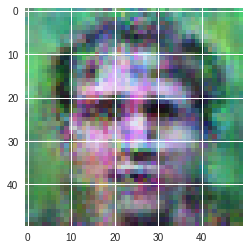

Iter: 96
D loss: 81.17
G_loss: 21.62

(50, 50, 3)


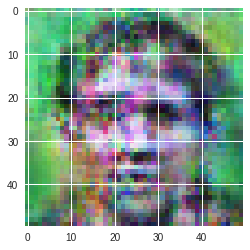

Iter: 97
D loss: 12.07
G_loss: 48.3

(50, 50, 3)


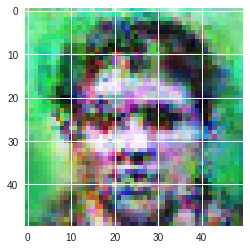

Iter: 98
D loss: 50.77
G_loss: 17.61

(50, 50, 3)


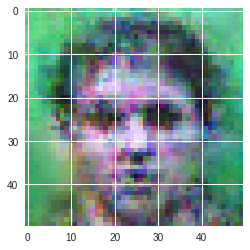

Iter: 99
D loss: 1.119
G_loss: 206.9

(50, 50, 3)


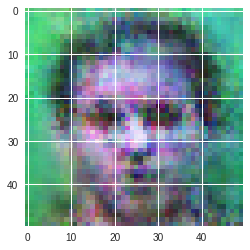

Iter: 100
D loss: 62.83
G_loss: 153.7

(50, 50, 3)


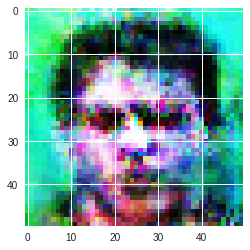

Iter: 101
D loss: 102.1
G_loss: 19.68

(50, 50, 3)


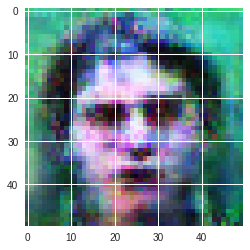

Iter: 102
D loss: 20.23
G_loss: 144.8

(50, 50, 3)


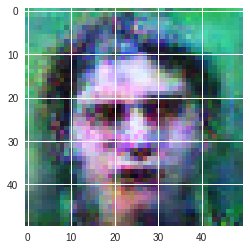

Iter: 103
D loss: 22.15
G_loss: 48.26

(50, 50, 3)


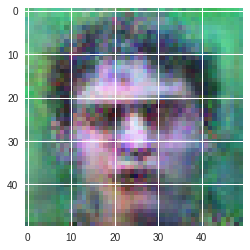

Iter: 104
D loss: 106.2
G_loss: 5.312

(50, 50, 3)


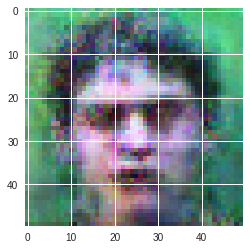

Iter: 105
D loss: 0.315
G_loss: 90.26

(50, 50, 3)


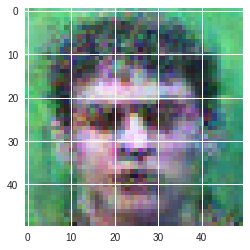

Iter: 106
D loss: 9.399
G_loss: 43.9

(50, 50, 3)


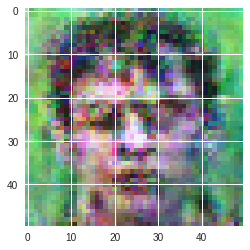

Iter: 107
D loss: 0.177
G_loss: 118.5

(50, 50, 3)


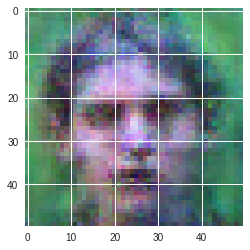

Iter: 108
D loss: 4.059
G_loss: 86.86

(50, 50, 3)


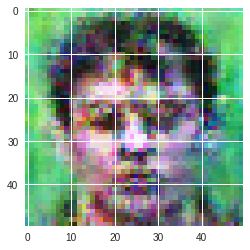

Iter: 109
D loss: 91.59
G_loss: 9.781

(50, 50, 3)


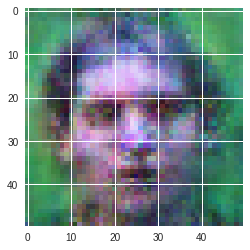

Iter: 110
D loss: 14.18
G_loss: 28.47

(50, 50, 3)


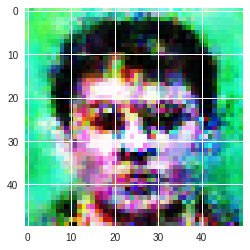

Iter: 111
D loss: 2.435
G_loss: 34.99

(50, 50, 3)


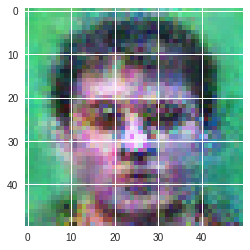

Iter: 112
D loss: 0.1733
G_loss: 46.22

(50, 50, 3)


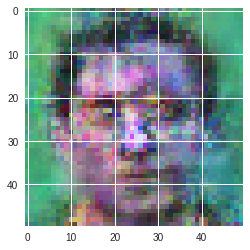

Iter: 113
D loss: 11.19
G_loss: 25.64

(50, 50, 3)


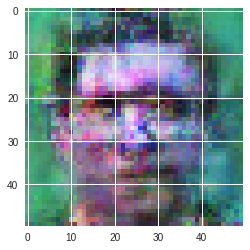

Iter: 114
D loss: 38.7
G_loss: 0.9628

(50, 50, 3)


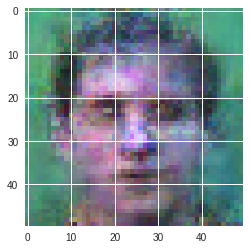

Iter: 115
D loss: 40.87
G_loss: 16.48

(50, 50, 3)


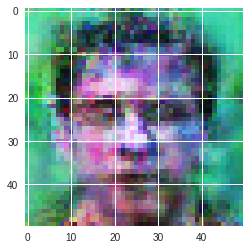

Iter: 116
D loss: 16.32
G_loss: 31.39

(50, 50, 3)


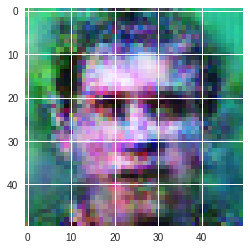

Iter: 117
D loss: 14.81
G_loss: 43.26

(50, 50, 3)


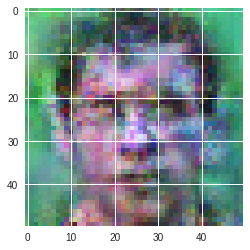

Iter: 118
D loss: 50.9
G_loss: 14.78

(50, 50, 3)


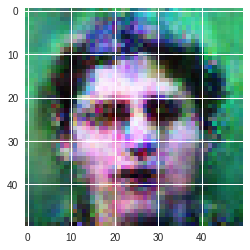

Iter: 119
D loss: 12.25
G_loss: 33.83

(50, 50, 3)


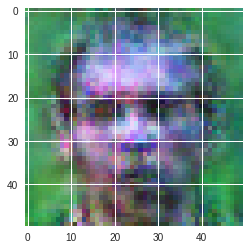

Iter: 120
D loss: 54.66
G_loss: 0.6626

(50, 50, 3)


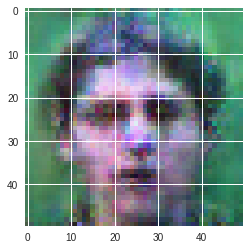

Iter: 121
D loss: 4.466
G_loss: 50.3

(50, 50, 3)


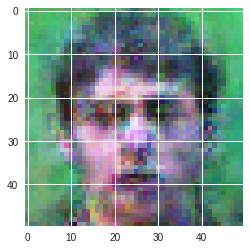

Iter: 122
D loss: 11.37
G_loss: 17.04

(50, 50, 3)


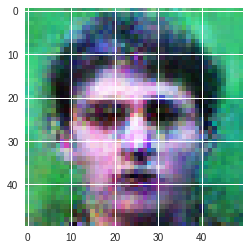

Iter: 123
D loss: 206.1
G_loss: 117.5

(50, 50, 3)


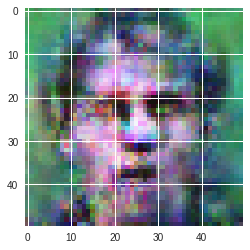

Iter: 124
D loss: 14.77
G_loss: 43.98

(50, 50, 3)


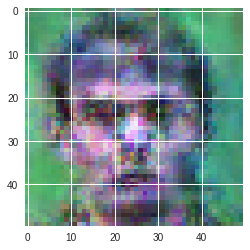

Iter: 125
D loss: 62.1
G_loss: 65.04

(50, 50, 3)


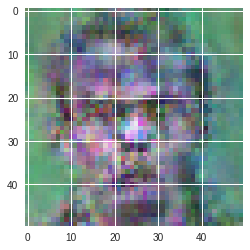

Iter: 126
D loss: 12.35
G_loss: 21.33

(50, 50, 3)


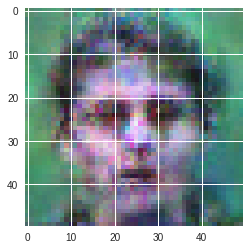

Iter: 127
D loss: 4.167
G_loss: 27.68

(50, 50, 3)


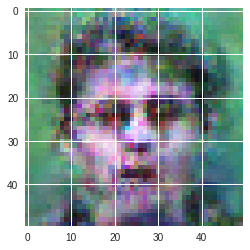

Iter: 128
D loss: 1.364
G_loss: 63.28

(50, 50, 3)


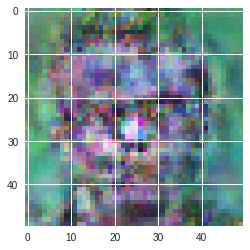

Iter: 129
D loss: 22.07
G_loss: 16.34

(50, 50, 3)


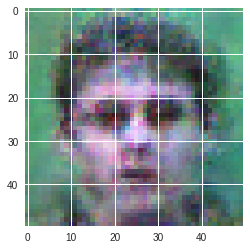

Iter: 130
D loss: 106.3
G_loss: 35.17

(50, 50, 3)


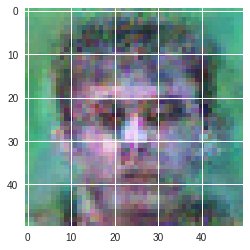

Iter: 131
D loss: 2.366
G_loss: 41.41

(50, 50, 3)


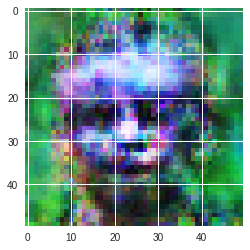

Iter: 132
D loss: 10.47
G_loss: 26.2

(50, 50, 3)


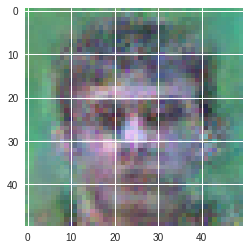

Iter: 133
D loss: 7.947
G_loss: 34.21

(50, 50, 3)


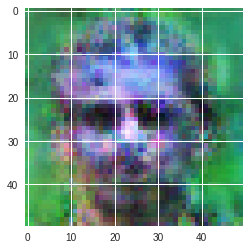

Iter: 134
D loss: 25.02
G_loss: 15.52

(50, 50, 3)


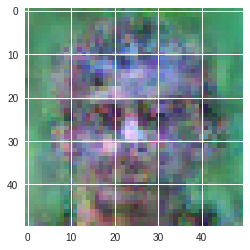

Iter: 135
D loss: 3.062
G_loss: 34.52

(50, 50, 3)


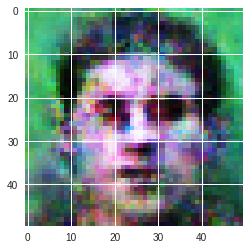

Iter: 136
D loss: 14.77
G_loss: 9.23

(50, 50, 3)


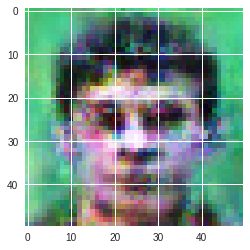

Iter: 137
D loss: 4.449
G_loss: 20.4

(50, 50, 3)


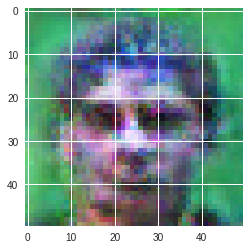

Iter: 138
D loss: 5.666
G_loss: 21.64

(50, 50, 3)


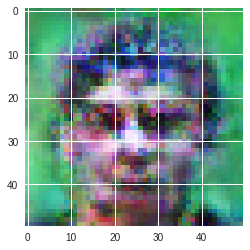

Iter: 139
D loss: 21.12
G_loss: 11.97

(50, 50, 3)


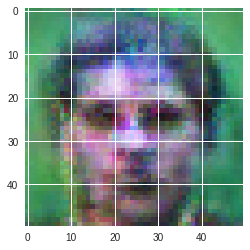

Iter: 140
D loss: 16.71
G_loss: 60.9

(50, 50, 3)


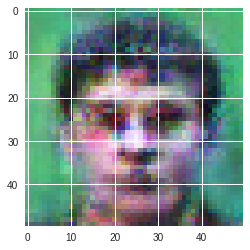

Iter: 141
D loss: 7.38
G_loss: 17.37

(50, 50, 3)


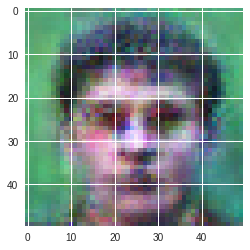

Iter: 142
D loss: 10.04
G_loss: 20.76

(50, 50, 3)


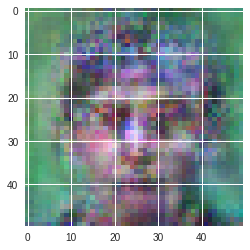

Iter: 143
D loss: 0.2525
G_loss: 23.59

(50, 50, 3)


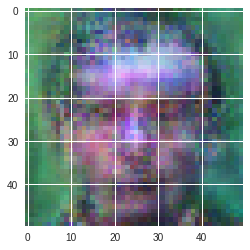

Iter: 144
D loss: 2.892
G_loss: 36.25

(50, 50, 3)


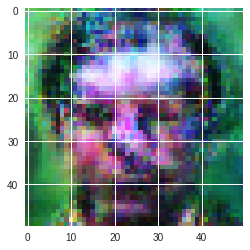

Iter: 145
D loss: 37.64
G_loss: 2.099

(50, 50, 3)


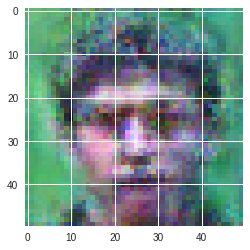

Iter: 146
D loss: 2.68
G_loss: 16.44

(50, 50, 3)


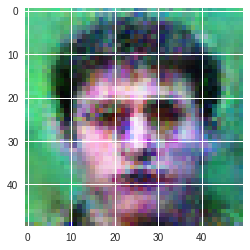

Iter: 147
D loss: 24.88
G_loss: 14.28

(50, 50, 3)


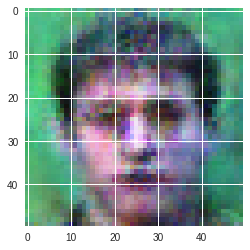

Iter: 148
D loss: 18.69
G_loss: 7.606

(50, 50, 3)


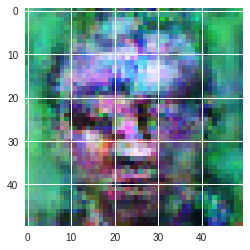

Iter: 149
D loss: 52.09
G_loss: 4.567e-05

(50, 50, 3)


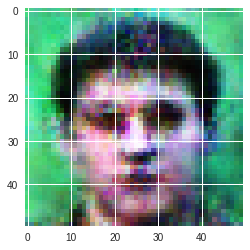

Iter: 150
D loss: 0.1581
G_loss: 28.69

(50, 50, 3)


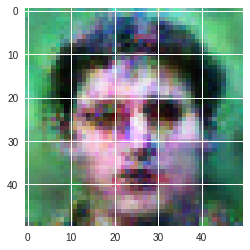

Iter: 151
D loss: 1.512
G_loss: 12.86

(50, 50, 3)


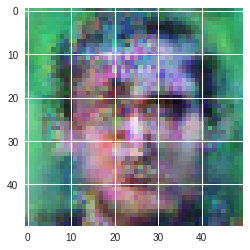

Iter: 152
D loss: 0.4778
G_loss: 16.79

(50, 50, 3)


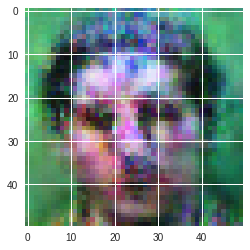

Iter: 153
D loss: 8.405
G_loss: 3.616

(50, 50, 3)


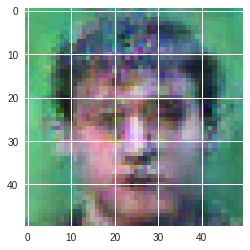

Iter: 154
D loss: 0.3591
G_loss: 7.76

(50, 50, 3)


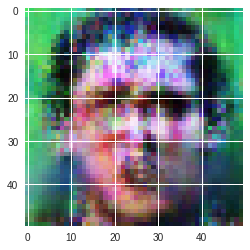

Iter: 155
D loss: 3.219
G_loss: 2.382

(50, 50, 3)


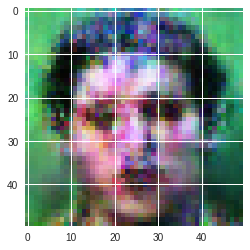

Iter: 156
D loss: 0.04844
G_loss: 13.13

(50, 50, 3)


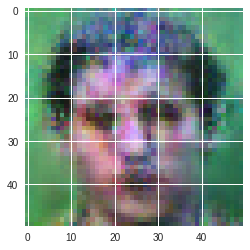

Iter: 157
D loss: 3.533
G_loss: 5.056

(50, 50, 3)


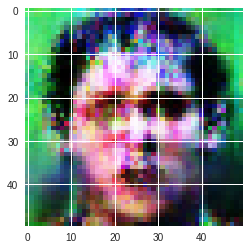

Iter: 158
D loss: 1.121e-06
G_loss: 28.05

(50, 50, 3)


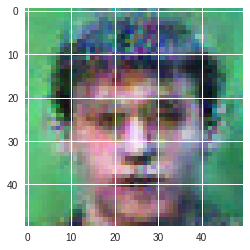

Iter: 159
D loss: 4.7
G_loss: 8.678

(50, 50, 3)


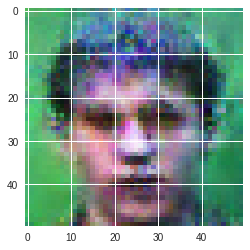

Iter: 160
D loss: 5.715e-07
G_loss: 25.88

(50, 50, 3)


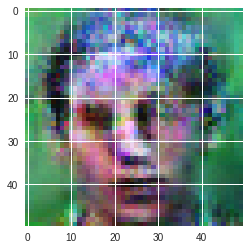

Iter: 161
D loss: 0.1498
G_loss: 18.32

(50, 50, 3)


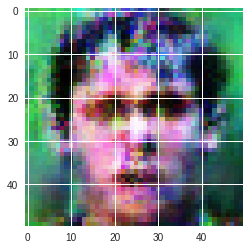

Iter: 162
D loss: 0.4129
G_loss: 8.23

(50, 50, 3)


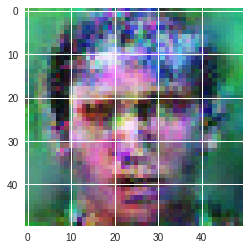

Iter: 163
D loss: 1.079
G_loss: 4.275

(50, 50, 3)


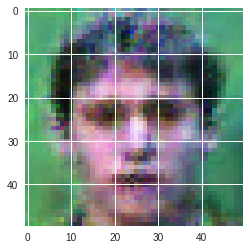

Iter: 164
D loss: 2.419
G_loss: 3.679

(50, 50, 3)


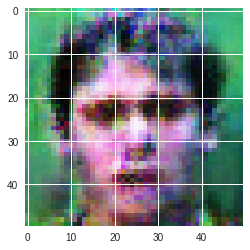

Iter: 165
D loss: 1.113
G_loss: 10.89

(50, 50, 3)


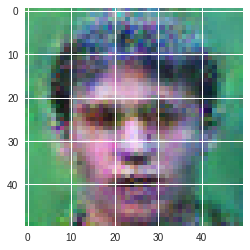

Iter: 166
D loss: 5.801
G_loss: 26.38

(50, 50, 3)


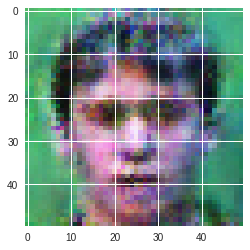

Iter: 167
D loss: 0.9831
G_loss: 17.67

(50, 50, 3)


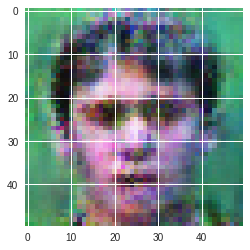

Iter: 168
D loss: 1.821
G_loss: 15.46

(50, 50, 3)


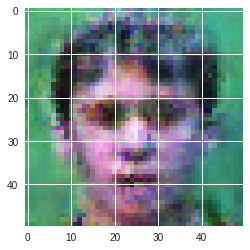

Iter: 169
D loss: 0.7998
G_loss: 13.01

(50, 50, 3)


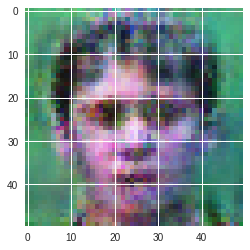

Iter: 170
D loss: 12.1
G_loss: 11.68

(50, 50, 3)


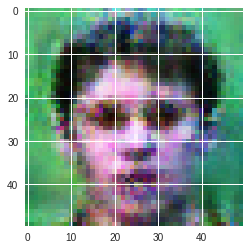

Iter: 171
D loss: 0.2662
G_loss: 19.8

(50, 50, 3)


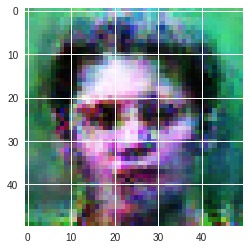

Iter: 172
D loss: 0.1833
G_loss: 21.82

(50, 50, 3)


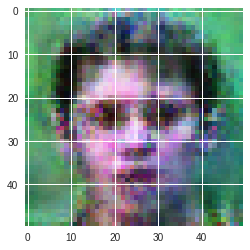

Iter: 173
D loss: 53.11
G_loss: 1.487

(50, 50, 3)


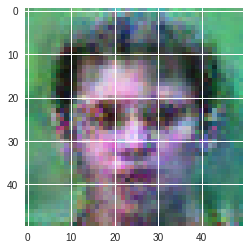

Iter: 174
D loss: 1.218
G_loss: 26.5

(50, 50, 3)


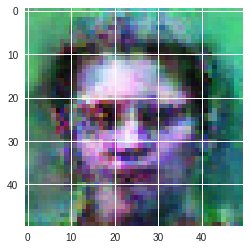

Iter: 175
D loss: 18.2
G_loss: 4.183

(50, 50, 3)


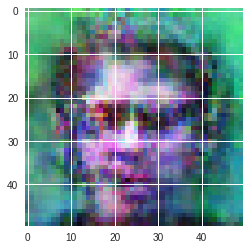

Iter: 176
D loss: 2.361
G_loss: 40.78

(50, 50, 3)


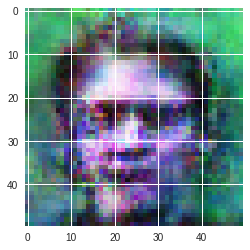

Iter: 177
D loss: 1.021
G_loss: 44.21

(50, 50, 3)


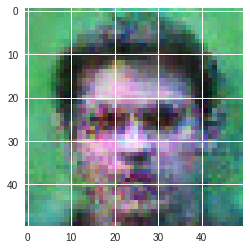

Iter: 178
D loss: 5.766
G_loss: 16.35

(50, 50, 3)


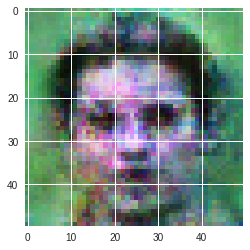

Iter: 179
D loss: 1.71
G_loss: 44.54

(50, 50, 3)


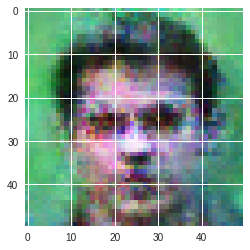

Iter: 180
D loss: 9.467
G_loss: 11.07

(50, 50, 3)


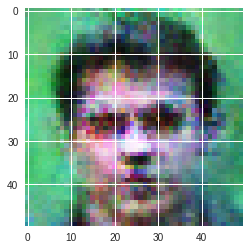

Iter: 181
D loss: 1.713
G_loss: 32.95

(50, 50, 3)


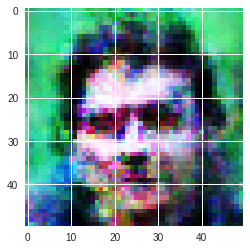

Iter: 182
D loss: 0.6007
G_loss: 18.73

(50, 50, 3)


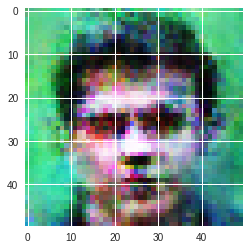

Iter: 183
D loss: 18.88
G_loss: 1.156

(50, 50, 3)


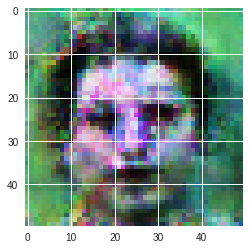

Iter: 184
D loss: 1.344
G_loss: 17.5

(50, 50, 3)


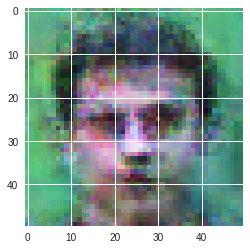

Iter: 185
D loss: 1.36
G_loss: 32.35

(50, 50, 3)


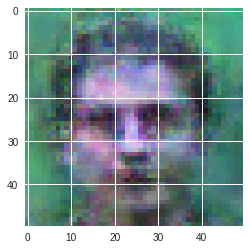

Iter: 186
D loss: 1.813
G_loss: 16.38

(50, 50, 3)


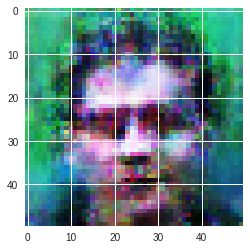

Iter: 187
D loss: 5.352
G_loss: 6.091

(50, 50, 3)


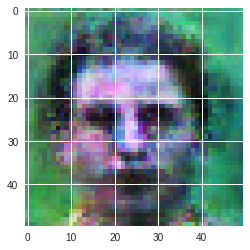

Iter: 188
D loss: 14.13
G_loss: 0.2212

(50, 50, 3)


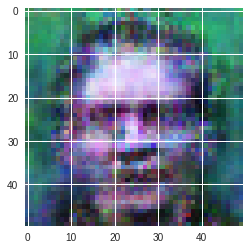

Iter: 189
D loss: 1.158
G_loss: 15.63

(50, 50, 3)


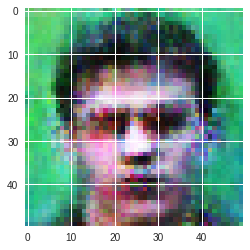

Iter: 190
D loss: 10.66
G_loss: 0.3288

(50, 50, 3)


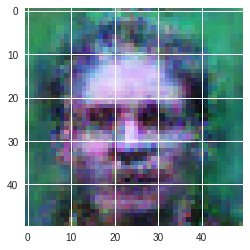

Iter: 191
D loss: 2.107
G_loss: 3.014

(50, 50, 3)


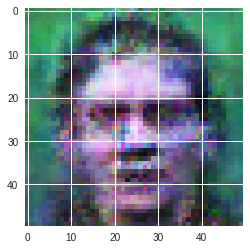

Iter: 192
D loss: 1.625
G_loss: 7.552

(50, 50, 3)


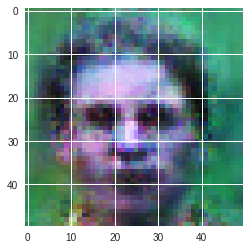

Iter: 193
D loss: 1.127
G_loss: 2.832

(50, 50, 3)


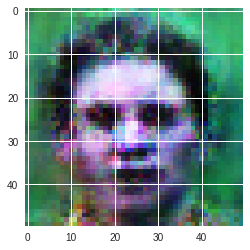

Iter: 194
D loss: 0.4428
G_loss: 2.186

(50, 50, 3)


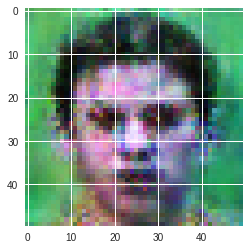

Iter: 195
D loss: 2.865
G_loss: 0.8905

(50, 50, 3)


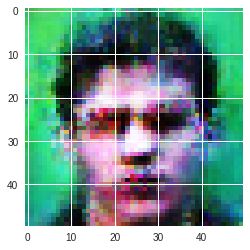

Iter: 196
D loss: 11.89
G_loss: 0.9031

(50, 50, 3)


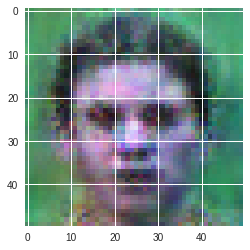

Iter: 197
D loss: 0.2285
G_loss: 2.721

(50, 50, 3)


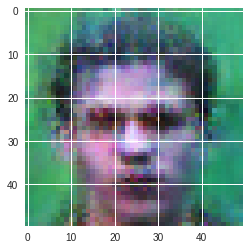

Iter: 198
D loss: 0.2631
G_loss: 2.837

(50, 50, 3)


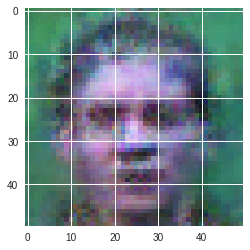

Iter: 199
D loss: 0.1598
G_loss: 2.945

(50, 50, 3)


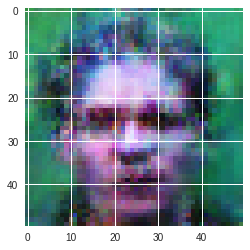

Iter: 200
D loss: 0.1072
G_loss: 3.003

(50, 50, 3)


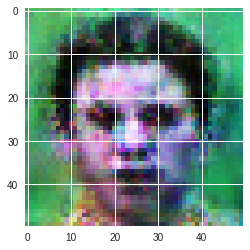

Iter: 201
D loss: 0.2869
G_loss: 3.093

(50, 50, 3)


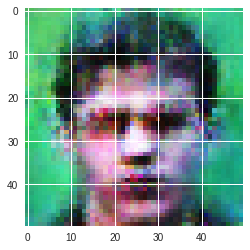

Iter: 202
D loss: 0.1976
G_loss: 2.736

(50, 50, 3)


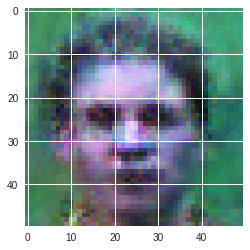

Iter: 203
D loss: 0.04105
G_loss: 3.701

(50, 50, 3)


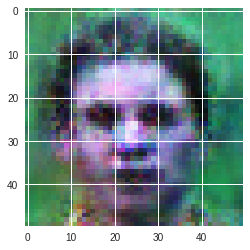

Iter: 204
D loss: 0.1075
G_loss: 3.052

(50, 50, 3)


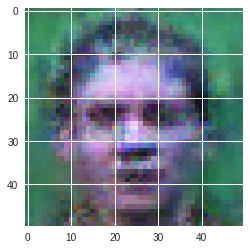

Iter: 205
D loss: 0.1413
G_loss: 3.02

(50, 50, 3)


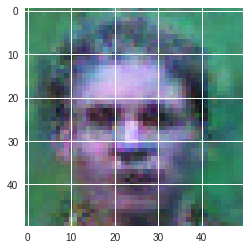

Iter: 206
D loss: 0.1452
G_loss: 2.96

(50, 50, 3)


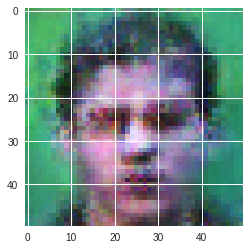

Iter: 207
D loss: 0.06607
G_loss: 3.15

(50, 50, 3)


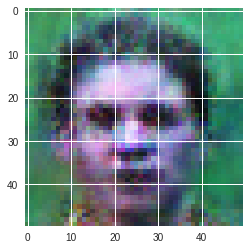

Iter: 208
D loss: 0.04589
G_loss: 3.435

(50, 50, 3)


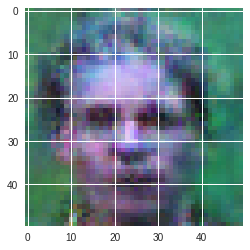

Iter: 209
D loss: 0.04919
G_loss: 3.247

(50, 50, 3)


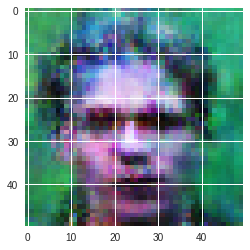

Iter: 210
D loss: 0.1203
G_loss: 2.923

(50, 50, 3)


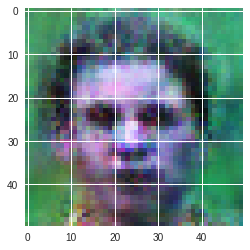

Iter: 211
D loss: 0.09588
G_loss: 2.735

(50, 50, 3)


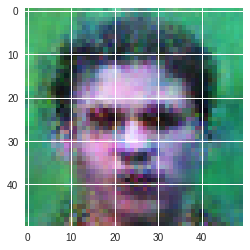

Iter: 212
D loss: 0.0225
G_loss: 3.876

(50, 50, 3)


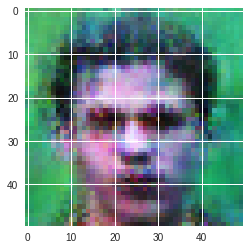

Iter: 213
D loss: 0.03586
G_loss: 3.483

(50, 50, 3)


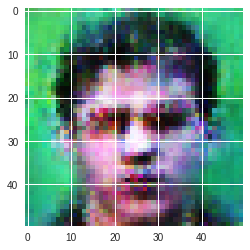

Iter: 214
D loss: 0.02731
G_loss: 3.744

(50, 50, 3)


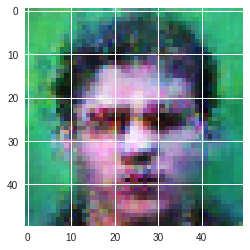

Iter: 215
D loss: 0.027
G_loss: 3.784

(50, 50, 3)


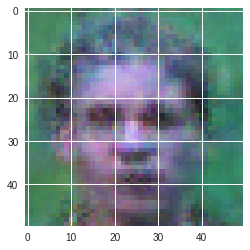

Iter: 216
D loss: 0.1747
G_loss: 2.88

(50, 50, 3)


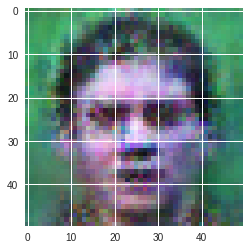

Iter: 217
D loss: 0.2154
G_loss: 1.911

(50, 50, 3)


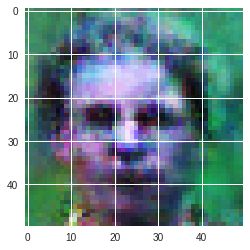

Iter: 218
D loss: 0.4799
G_loss: 1.44

(50, 50, 3)


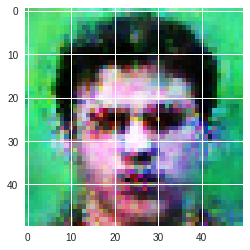

Iter: 219
D loss: 0.4523
G_loss: 0.9702

(50, 50, 3)


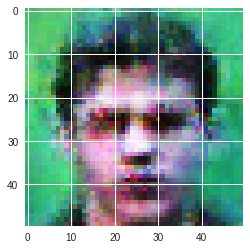

Iter: 220
D loss: 0.03009
G_loss: 3.652

(50, 50, 3)


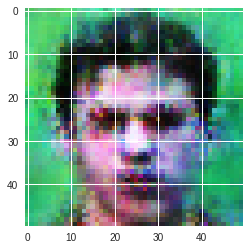

Iter: 221
D loss: 0.03581
G_loss: 3.571

(50, 50, 3)


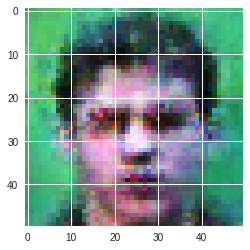

Iter: 222
D loss: 0.03167
G_loss: 3.584

(50, 50, 3)


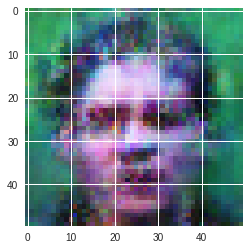

Iter: 223
D loss: 0.03254
G_loss: 3.764

(50, 50, 3)


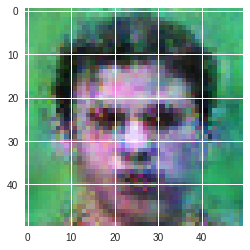

Iter: 224
D loss: 0.04047
G_loss: 3.702

(50, 50, 3)


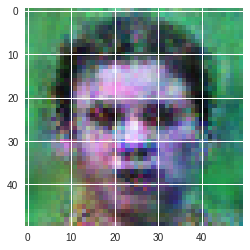

Iter: 225
D loss: 0.1061
G_loss: 2.272

(50, 50, 3)


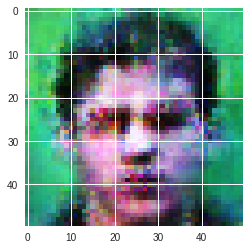

Iter: 226
D loss: 0.02562
G_loss: 3.725

(50, 50, 3)


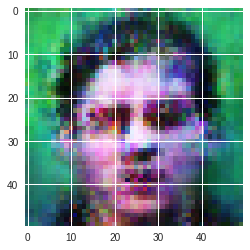

Iter: 227
D loss: 0.03143
G_loss: 3.43

(50, 50, 3)


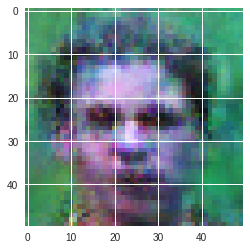

Iter: 228
D loss: 0.03766
G_loss: 3.719

(50, 50, 3)


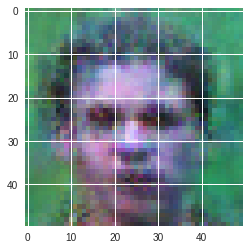

Iter: 229
D loss: 0.1583
G_loss: 1.965

(50, 50, 3)


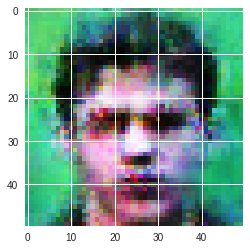

Iter: 230
D loss: 0.1261
G_loss: 2.576

(50, 50, 3)


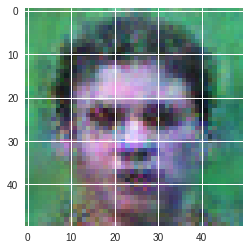

Iter: 231
D loss: 0.06918
G_loss: 2.98

(50, 50, 3)


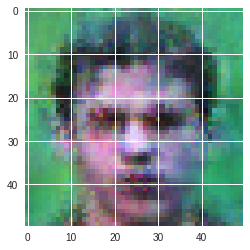

Iter: 232
D loss: 0.02668
G_loss: 3.842

(50, 50, 3)


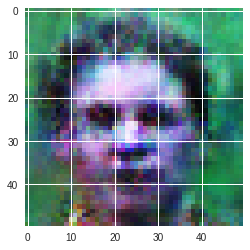

Iter: 233
D loss: 0.01021
G_loss: 4.658

(50, 50, 3)


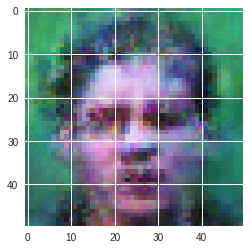

Iter: 234
D loss: 0.01567
G_loss: 4.431

(50, 50, 3)


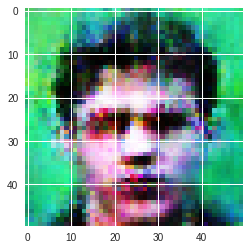

Iter: 235
D loss: 0.4909
G_loss: 4.385

(50, 50, 3)


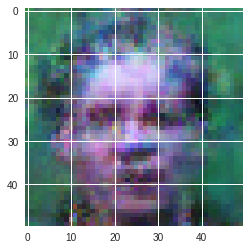

Iter: 236
D loss: 0.07219
G_loss: 3.518

(50, 50, 3)


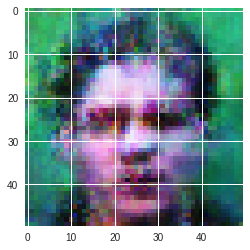

Iter: 237
D loss: 0.08935
G_loss: 3.033

(50, 50, 3)


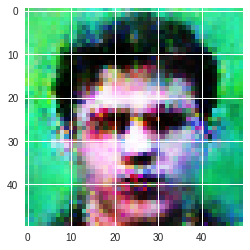

Iter: 238
D loss: 0.1291
G_loss: 2.875

(50, 50, 3)


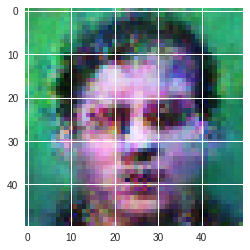

Iter: 239
D loss: 0.1647
G_loss: 4.521

(50, 50, 3)


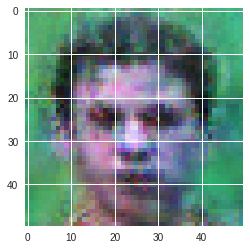

Iter: 240
D loss: 0.03038
G_loss: 4.53

(50, 50, 3)


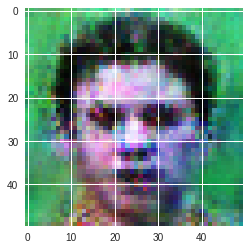

Iter: 241
D loss: 0.02239
G_loss: 4.66

(50, 50, 3)


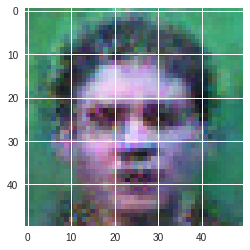

Iter: 242
D loss: 0.02116
G_loss: 4.294

(50, 50, 3)


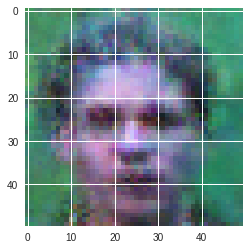

Iter: 243
D loss: 0.07187
G_loss: 4.115

(50, 50, 3)


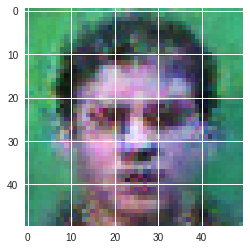

Iter: 244
D loss: 0.4433
G_loss: 3.526

(50, 50, 3)


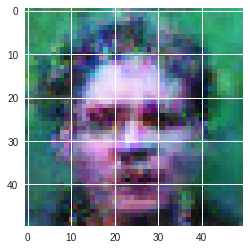

Iter: 245
D loss: 0.03137
G_loss: 4.036

(50, 50, 3)


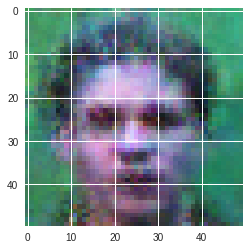

Iter: 246
D loss: 0.0642
G_loss: 4.17

(50, 50, 3)


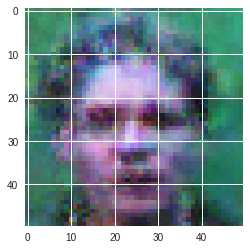

Iter: 247
D loss: 0.0317
G_loss: 3.794

(50, 50, 3)


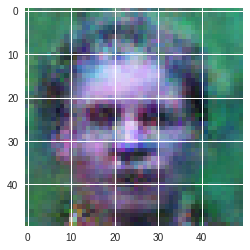

Iter: 248
D loss: 0.3476
G_loss: 1.941

(50, 50, 3)


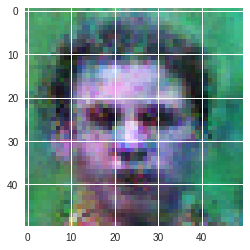

Iter: 249
D loss: 0.1819
G_loss: 3.362

(50, 50, 3)


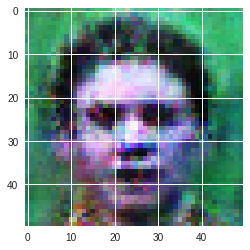

Iter: 250
D loss: 0.06892
G_loss: 3.468

(50, 50, 3)


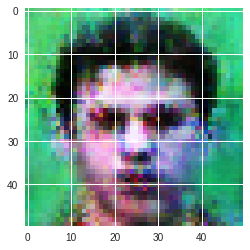

Iter: 251
D loss: 0.03406
G_loss: 3.986

(50, 50, 3)


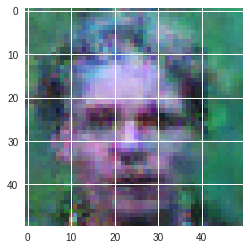

Iter: 252
D loss: 0.04283
G_loss: 4.176

(50, 50, 3)


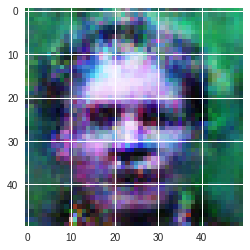

Iter: 253
D loss: 0.01724
G_loss: 4.116

(50, 50, 3)


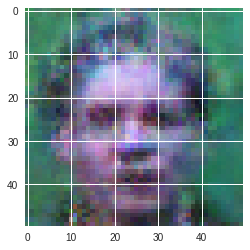

Iter: 254
D loss: 0.06359
G_loss: 4.139

(50, 50, 3)


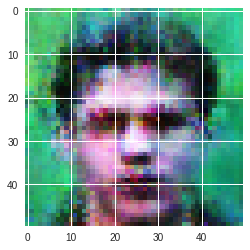

Iter: 255
D loss: 0.02291
G_loss: 4.089

(50, 50, 3)


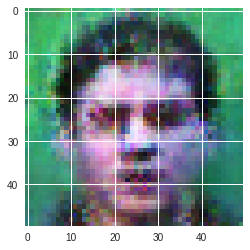

Iter: 256
D loss: 0.02152
G_loss: 4.016

(50, 50, 3)


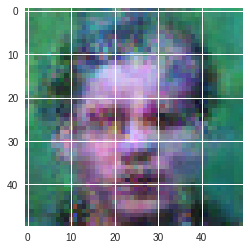

Iter: 257
D loss: 0.05793
G_loss: 4.232

(50, 50, 3)


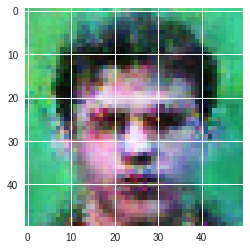

Iter: 258
D loss: 0.2145
G_loss: 4.314

(50, 50, 3)


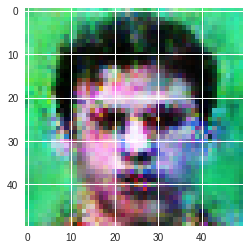

Iter: 259
D loss: 0.1559
G_loss: 2.799

(50, 50, 3)


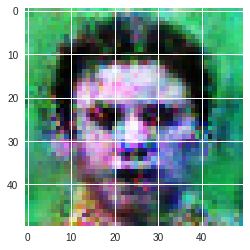

Iter: 260
D loss: 0.02839
G_loss: 4.084

(50, 50, 3)


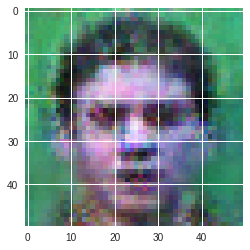

Iter: 261
D loss: 0.0249
G_loss: 4.156

(50, 50, 3)


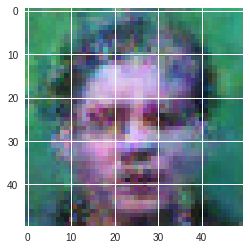

Iter: 262
D loss: 0.02647
G_loss: 4.05

(50, 50, 3)


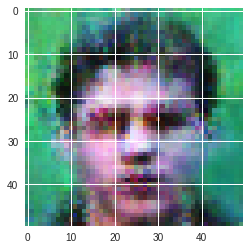

Iter: 263
D loss: 0.02039
G_loss: 4.263

(50, 50, 3)


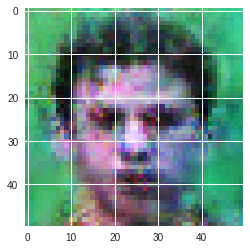

Iter: 264
D loss: 0.02148
G_loss: 4.102

(50, 50, 3)


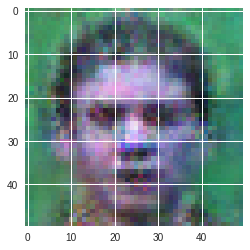

Iter: 265
D loss: 0.1334
G_loss: 3.492

(50, 50, 3)


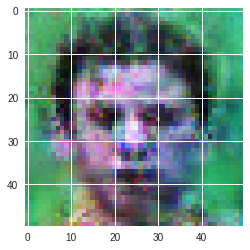

Iter: 266
D loss: 0.06669
G_loss: 3.327

(50, 50, 3)


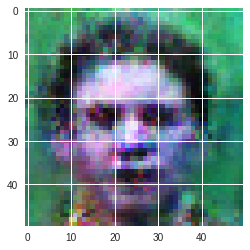

Iter: 267
D loss: 0.178
G_loss: 4.243

(50, 50, 3)


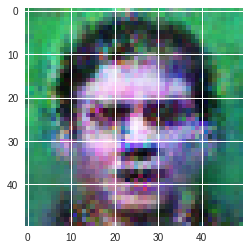

Iter: 268
D loss: 0.03396
G_loss: 4.191

(50, 50, 3)


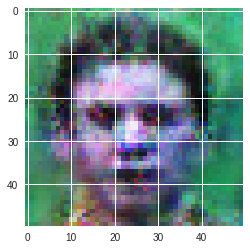

Iter: 269
D loss: 0.02204
G_loss: 4.19

(50, 50, 3)


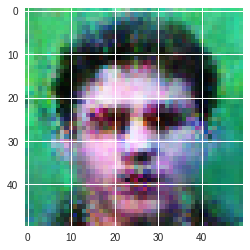

Iter: 270
D loss: 1.376
G_loss: 3.654

(50, 50, 3)


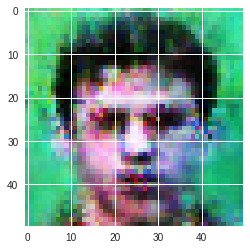

Iter: 271
D loss: 0.01809
G_loss: 4.071



In [0]:
train_nn()